In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
from scipy import linalg
import pandas as pd
import os

if not os.path.exists('Results'):
    os.makedirs('Results')
if not os.path.exists('Models'):
    os.makedirs('Models')

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [2]:
LR = 5e-5
BATCH_SIZE = 64
IMG_SIZE = 64
IMG_CHANNELS = 3
LATENT_DIM = 100
EPOCHS = 40
DISC_FEATURES = 64
GEN_FEATURES = 64
NUM_CLASSES = 10
EMBED_SIZE = 100
CRITIC_ITERATIONS = 5

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Files already downloaded and verified


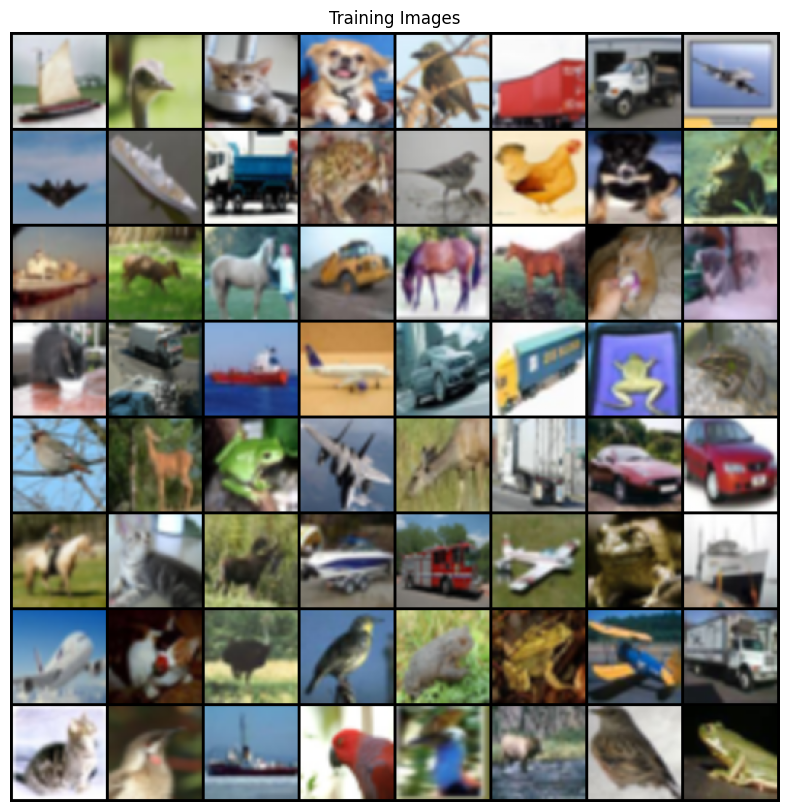

In [3]:
cifar10_dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

real_batch = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [4]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, latent_dim, img_channels, gen_features):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.gen_net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embed_size, gen_features * 16, 4, 1, 0, bias=False),
            self.gen_block(gen_features * 16, gen_features * 8, 4, 2, 1),
            self.gen_block(gen_features * 8, gen_features * 4, 4, 2, 1),
            self.gen_block(gen_features * 4, gen_features * 2, 4, 2, 1),
            nn.ConvTranspose2d(gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        gen_input = torch.cat([noise, embedding], dim=1)
        img = self.gen_net(gen_input)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.disc_net = nn.Sequential(
            nn.Conv2d(img_channels, disc_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.disc_block(disc_features, disc_features * 2, 4, 2, 1),
            self.disc_block(disc_features * 2, disc_features * 4, 4, 2, 1),
            self.disc_block(disc_features * 4, disc_features * 8, 4, 2, 1),
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(disc_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.label_layer = nn.Sequential(
            nn.Conv2d(disc_features * 8, 11, 4, 1, 0, bias=False),
            nn.LogSoftmax(dim=1)
        )
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    def disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, img):
        disc_features = self.disc_net(img)
        validity = self.validity_layer(disc_features).view(-1)
        label = self.label_layer(disc_features).view(-1, 11)
        return validity, label

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
generator = Generator(NUM_CLASSES, IMG_SIZE, EMBED_SIZE, LATENT_DIM, IMG_CHANNELS, GEN_FEATURES).to(device)
discriminator = Discriminator(NUM_CLASSES, IMG_SIZE, IMG_CHANNELS, DISC_FEATURES).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

generator.train()
discriminator.train()

fixed_noise = torch.randn(32, LATENT_DIM, 1, 1).to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

criterion = nn.BCELoss()

gen_losses = []
disc_losses = []
generated_images = []
fid_scores = []
iterations = 0

In [7]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [6]:
print("Training")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch += 1
    for batch_idx, (real_images, labels) in enumerate(data_loader):
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.shape[0]

        # Train Discriminator
        fake_labels = 10 * torch.ones((batch_size,), dtype=torch.long).to(device)
        optimizer_D.zero_grad()

        # Train with real images
        real_labels = torch.full((batch_size,), 1.0, dtype=torch.float).to(device)
        disc_real_val, disc_real_labels = discriminator(real_images)
        loss_disc_real_val = criterion(disc_real_val, real_labels)
        loss_disc_real_labels = F.nll_loss(disc_real_labels, labels)
        disc_real_loss = loss_disc_real_val + loss_disc_real_labels
        disc_real_loss.backward()

        # Train with fake images
        sample_labels = torch.randint(0, 10, (batch_size,), dtype=torch.long).to(device)
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
        fake_images = generator(noise, sample_labels)
        disc_fake_val, disc_fake_labels = discriminator(fake_images.detach())
        real_labels.fill_(0.0)
        loss_disc_fake_val = criterion(disc_fake_val, real_labels)
        loss_disc_fake_labels = F.nll_loss(disc_fake_labels, fake_labels)
        disc_fake_loss = loss_disc_fake_val + loss_disc_fake_labels
        disc_fake_loss.backward()

        # Update discriminator
        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
        sample_labels = torch.randint(0, 10, (batch_size,), dtype=torch.long).to(device)
        real_labels.fill_(1.0)
        fake_images = generator(noise, sample_labels)
        gen_val, gen_labels = discriminator(fake_images)
        loss_gen_val = criterion(gen_val, real_labels)
        loss_gen_labels = F.nll_loss(gen_labels, sample_labels)
        gen_loss = loss_gen_val + loss_gen_labels
        gen_loss.backward()
        optimizer_G.step()

        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())

        if (iterations % 500 == 0) or ((epoch == EPOCHS) and (batch_idx == len(data_loader) - 1)):
            with torch.no_grad():
                fake_images = generator(fixed_noise, sample_labels).detach().cpu()
                generated_images.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iterations += 1

        # Calculate FID
        fid = calculate_fid(real_images, fake_images, inception_model)
        fid_scores.append(fid)

        if epoch % 5 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(data_loader)} "
                  f"Discriminator Loss: {disc_loss:.3f}, Generator Loss: {gen_loss:.3f}, FID Score: {fid:.3f}")

    # Save generated images
    if not os.path.exists('Results/ACGAN_FAKE'):
        os.makedirs('Results/ACGAN_FAKE')
    if not os.path.exists('Results/ACGAN_REAL'):
        os.makedirs('Results/ACGAN_REAL')
    utils.save_image(fake_images, f'Results/ACGAN_FAKE/ACGAN_epoch_{epoch:03d}.png', normalize=True)
    utils.save_image(real_images, f'Results/ACGAN_REAL/ACGAN_epoch_{epoch:03d}.png', normalize=True)

end_time = time.time()
print(f'\n\nElapsed time: {end_time - start_time:.2f} seconds.')

if not os.path.exists('Results/Loss_Data'):
    os.makedirs('Results/Loss_Data')

np.save('Results/Loss_Data/ACGAN_GLoss', gen_losses)
np.save('Results/Loss_Data/ACGAN_DLoss', disc_losses)

gen_losses = np.load('Results/Loss_Data/ACGAN_GLoss.npy')
disc_losses = np.load('Results/Loss_Data/ACGAN_DLoss.npy')

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/LOSS.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

real_batch = next(iter(data_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, ncol=2, padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
plt.savefig('Results/ACGAN_Best_Fake_32.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
plt.title("FID Scores for ACGAN")
plt.plot(fid_scores, label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

if not os.path.exists('Results/FID_score'):
    os.makedirs('Results/FID_score')
np.save('Results/FID_score/ACGAN_FID', fid_scores)

print(f"FID Scores - Min: {np.min(fid_scores):.3f}, Max: {np.max(fid_scores):.3f}, Mean: {np.mean(fid_scores):.3f}, Last 5: {fid_scores[-5]:.3f}")
print(f"Generator Loss - Mean: {np.mean(gen_losses):.3f}, Min: {np.min(gen_losses):.3f}, Last: {gen_losses[-1]:.3f}")
print(f"Discriminator Loss - Mean: {np.mean(disc_losses):.3f}, Min: {np.min(disc_losses):.3f}, Last: {disc_losses[-1]:.3f}")


!!Training Started!!


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 64 for tensor number 1 in the list.